# Setup

In [1]:
import importlib
import os

import joblib
import pandas as pd

import tlp

url = 'https://lfs.aminer.cn/lab-datasets/dynamicinf/coauthor.zip'
dataset_id = '07'
adjusted_intervals = dict()

# Download and extract data

In [43]:
# filepath = f'{dataset_id}/edgelist.pkl'
# if not os.path.isfile(filepath):
#   edgelist = tlp.get_edgelist(url, dataset_id)
#   joblib.dump(edgelist, filepath)

import urllib
import zipfile

import pandas as pd

filepath = f'{dataset_id}/edgelist.pkl'
download_location = f'{dataset_id}/coauthor.zip'
extract_location = os.path.join(dataset_id, 'coauthor')
if not os.path.isfile(filepath):
  os.makedirs(dataset_id, exist_ok=True)
  
  if not os.path.isfile(download_location):
    urllib.request.urlretrieve(url, download_location)
  
  if not os.path.isdir(extract_location):
    with zipfile.ZipFile(download_location, 'r') as zip_ref:
      zip_ref.extractall(dataset_id)
  
  with open(os.path.join(extract_location, 'filelist.txt'), 'r') as f:
    filelist = f.read().splitlines()

  edgelist = pd.concat(
    {pd.Timestamp(year=int(file.split('.')[0]), month=1, day=1):
     pd.read_csv(os.path.join(extract_location, file), sep='\t', 
                 names=['source', 'target']) 
     for file in filelist},
    names=['datetime', 'index'])
  
  edgelist = edgelist.reset_index(level='datetime').reset_index(drop=True)
  edgelist.to_pickle(filepath)

# Splitting

In [44]:
%%time
filepath_edgelist = f'{dataset_id}/edgelist.pkl'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_probe = f'{dataset_id}/edgelist_probe.pkl'

if not os.path.isfile(filepath_mature) or not os.path.isfile(filepath_probe):
  edgelist_mature, edgelist_probe = tlp.split_in_intervals(
    edgelist=joblib.load(filepath_edgelist), **adjusted_intervals)
  joblib.dump(edgelist_mature, filepath_mature)
  joblib.dump(edgelist_probe, filepath_probe)

CPU times: user 844 ms, sys: 788 ms, total: 1.63 s
Wall time: 1.93 s


# Instances

In [45]:
%%time
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances = f'{dataset_id}/instances.pkl'

if not os.path.isfile(filepath_instances):
  instances = tlp.get_instances(edgelist_mature=joblib.load(filepath_mature),
    verbose=True)
  joblib.dump(instances, filepath_instances)

CPU times: user 9min 26s, sys: 17.4 s, total: 9min 44s
Wall time: 9min 42s


# Targets

In [46]:
%%time
filepath_instances = f'{dataset_id}/instances.pkl'
filepath_probe = f'{dataset_id}/edgelist_probe.pkl'
filepath_targets = f'{dataset_id}/targets.pkl'

if not os.path.isfile(filepath_targets):
  targets = tlp.get_targets(
    instances=joblib.load(filepath_instances),
    edgelist_probe=joblib.load(filepath_probe),
    verbose=True)
  joblib.dump(targets, filepath_targets)

Determine targets:   0%|          | 0/45227943 [00:00<?, ?it/s]

CPU times: user 1min 6s, sys: 1.53 s, total: 1min 8s
Wall time: 1min 7s


# Sampling

In [47]:
%%time
filepath_instances = f'{dataset_id}/instances.pkl'
filepath_targets = f'{dataset_id}/edgelist_targets.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'
filepath_targets_sampled = f'{dataset_id}/targets_sampled.pkl'

if not (os.path.isfile(filepath_instances_sampled) and 
        os.path.isfile(filepath_targets_sampled)):
  instances_sampled, targets_sampled = tlp.balanced_sample(instances, targets)
  joblib.dump(instances_sampled, f'{dataset_id}/instances_sampled.pkl')
  joblib.dump(targets_sampled, f'{dataset_id}/targets_sampled.pkl')

CPU times: user 852 ms, sys: 114 ms, total: 966 ms
Wall time: 995 ms


# Features

## AA (time agnostic)

In [48]:
%%time
filepath = f'{dataset_id}/features'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'

adamic_adar_time_agnostic = tlp.features.adamic_adar_time_agnostic(
  edgelist=joblib.load(filepath_mature),
  instances=joblib.load(filepath_instances_sampled),
  path=filepath)

CPU times: user 35.7 s, sys: 853 ms, total: 36.6 s
Wall time: 36.6 s


## AA (time aware)

In [49]:
%%time
filepath = f'{dataset_id}/features'
filepath_mature = f'{dataset_id}/edgelist_mature.pkl'
filepath_instances_sampled = f'{dataset_id}/instances_sampled.pkl'

adamic_adar_time_aware = tlp.features.adamic_adar_time_aware(
  edgelist=joblib.load(filepath_mature),
  instances=joblib.load(filepath_instances_sampled),
  path=filepath,
  verbose=True)

time strategies:   0%|          | 0/3 [00:00<?, ?it/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

aggregation strategies:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

  0%|          | 0/20000 [00:00<?, ?instances/s]

CPU times: user 6min 40s, sys: 19.7 s, total: 6min 59s
Wall time: 6min 59s


# Analysis

## Figure: Edge distribution with maturing and probing intervals indicated

1986-01-01 00:00:00 2009-01-01 00:00:00 2012-01-01 00:00:00


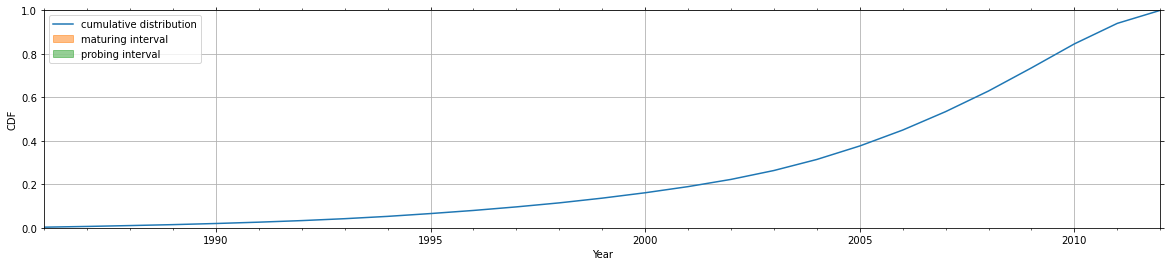

In [2]:
tlp.analysis.plot_datetime(
  joblib.load(f'{dataset_id}/edgelist.pkl')['datetime'])

## Metric: Class imbalance

In [51]:
tlp.analysis.class_imbalance(targets=joblib.load(f'{dataset_id}/targets.pkl'))

,absolute,relative
False,45159231,0.998481
True,68712,0.001519


## Figure: Datetime strategies

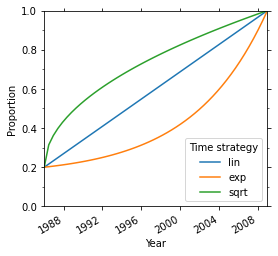

In [52]:
edgelist = joblib.load(f'{dataset_id}/edgelist_mature.pkl')
t = tlp.analysis.plot_datetime_strategies(edgelist['datetime'])

## Figure: Datetime distribution

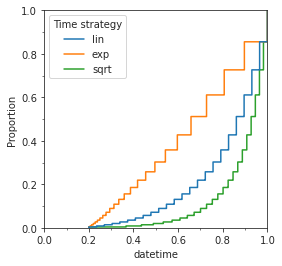

In [53]:
edgelist = joblib.load(f'{dataset_id}/edgelist_mature.pkl')
tlp.analysis.plot_datetime_distribution(edgelist['datetime'])

## Figure: Scores

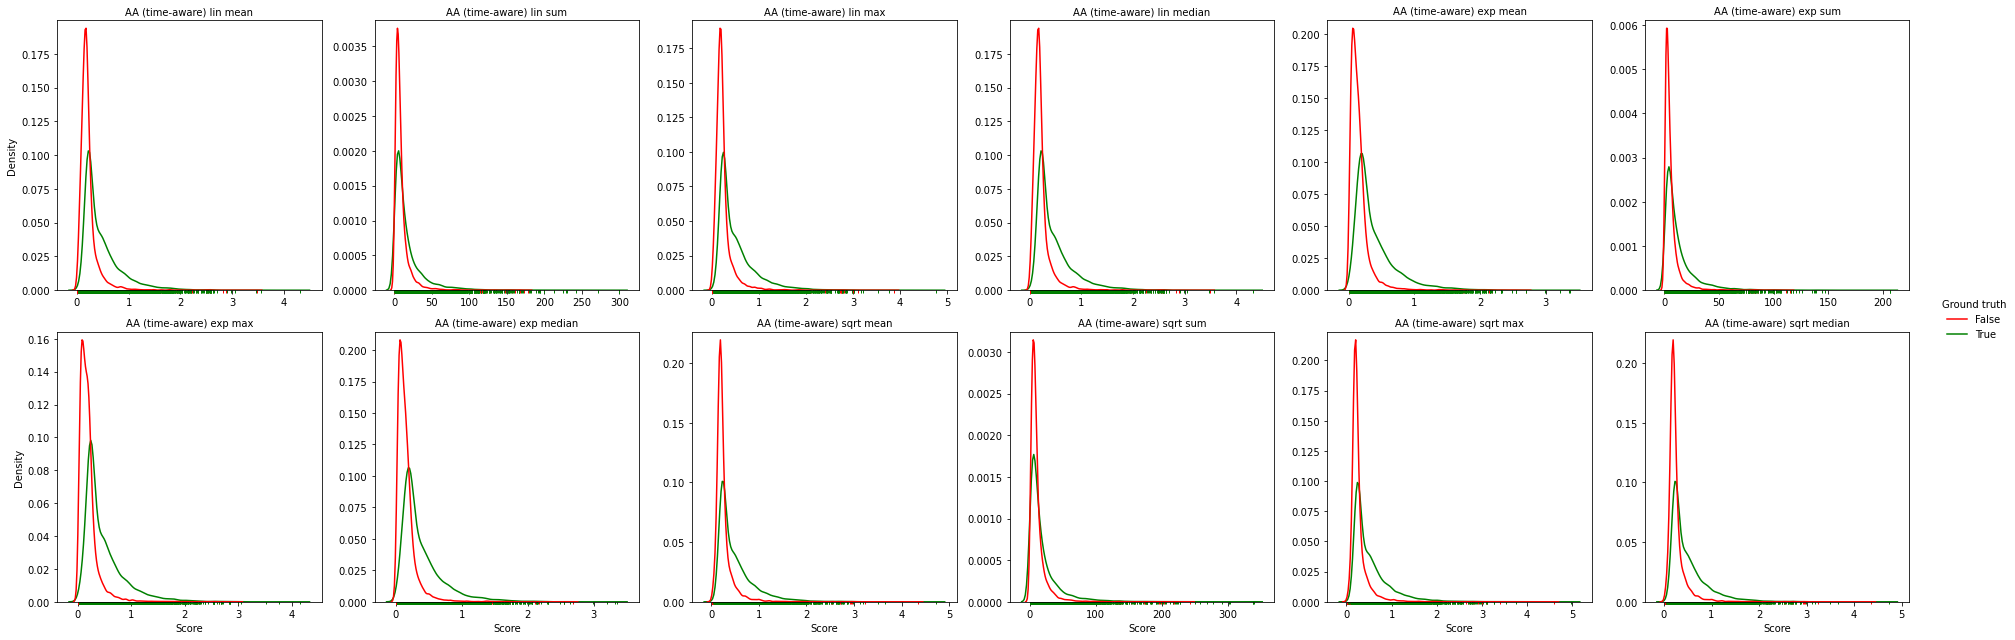

In [54]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  if file.is_file():
    feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.plot_score(feature_dict, targets)

## Figure: ROC

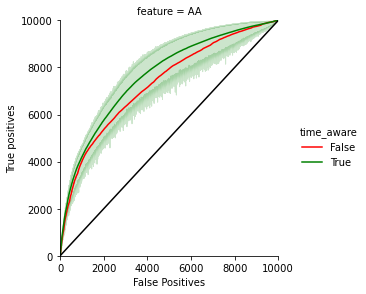

In [55]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  if file.is_file():
    feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.plot_roc_auc(feature_dict, targets)

## AUC

In [56]:
feature_dict = dict()
for file in os.scandir(f'{dataset_id}/features'):
  for file in os.scandir(f'{dataset_id}/features'):
    if file.is_file():
      feature_dict.update(joblib.load(file.path))
targets=joblib.load('01/targets_sampled.pkl')

tlp.analysis.get_auc(feature_dict, targets)

feature  time_aware  aggregation_strategy  time_strategy
AA       False       NaN                   NaN              0.731412
         True        mean                  lin              0.801657
                     sum                   lin              0.633011
                     max                   lin              0.805756
                     median                lin              0.801350
                     mean                  exp              0.820080
                     sum                   exp              0.702428
                     max                   exp              0.831147
                     median                exp              0.817228
                     mean                  sqrt             0.784612
                     sum                   sqrt             0.597763
                     max                   sqrt             0.785441
                     median                sqrt             0.784619
Name: auc, dtype: float64